In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/msrf/aug_data.zip .
!cp /content/drive/MyDrive/msrf/patched.zip .
!cp /content/drive/MyDrive/msrf/diu_net.py .
!cp /content/drive/MyDrive/msrf/patient_info_test.json .
!unzip aug_data.zip
!unzip patched.zip

In [3]:
import os
from diu_net import diu_net_model, dice_coef, iou, dice_coef_loss, aji
from PIL import Image
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [4]:
aug_dir = 'aug_data'
train_dir = os.path.join('patched', 'train')
test_dir = os.path.join('patched', 'test')

def load_data(train_dir, test_dir, aug_dir = None):
  train_im_dir = os.path.join(train_dir, 'tissues')
  train_ms_dir = os.path.join(train_dir, 'masks')

  test_im_dir = os.path.join(test_dir, 'tissues')
  test_ms_dir = os.path.join(test_dir, 'masks')

  if aug_dir is not None:
    aug_im_dir = os.path.join(aug_dir, 'images')
    aug_ms_dir = os.path.join(aug_dir, 'masks')

  train_im_list = [f[: -4] for f in os.listdir(train_im_dir)]
  aug_im_list = [f[: -4] for f in os.listdir(aug_im_dir)]
  test_im_list = [f[: -4] for f in os.listdir(test_im_dir)]

  if aug_dir is not None:
    x = np.zeros((len(train_im_list) + len(aug_im_list), 256, 256, 3), dtype = np.float32)
    y = np.zeros((len(train_im_list) + len(aug_im_list), 256, 256), dtype = np.float32)
  else:
    x = np.zeros((len(train_im_list), 256, 256, 3), dtype = np.float32)
    y = np.zeros((len(train_im_list), 256, 256), dtype = np.float32)

  for i, f in enumerate(tqdm(train_im_list, desc = 'Loading Training Data ...')):
    img = Image.open(os.path.join(train_im_dir, f + '.png'))
    msk = Image.open(os.path.join(train_ms_dir, f + '.png'))

    x[i] = np.array(img, dtype = np.float32)
    y[i] = np.array(msk, dtype = np.float32)

  if aug_dir is not None:
    for i, f in enumerate(tqdm(aug_im_list, desc = 'Loading Augmented Data ...')):
      img = Image.open(os.path.join(aug_im_dir, f + '.png'))
      msk = Image.open(os.path.join(aug_ms_dir, f + '.png'))
      
      x[len(train_im_list) + i - 1] = np.array(img, dtype = np.float32)
      y[len(train_im_list) + i - 1] = np.array(msk, dtype = np.float32)

  x_test = np.zeros((len(test_im_list), 256, 256, 3), dtype = np.float32)
  y_test = np.zeros((len(test_im_list), 256, 256), dtype = np.float32)

  for i, f in enumerate(tqdm(test_im_list, desc = 'Loading Testing Data ...')):
    img = Image.open(os.path.join(test_im_dir, f + '.png'))
    msk = Image.open(os.path.join(test_ms_dir, f + '.png'))

    x_test[i] = np.array(img, dtype = np.float32)
    y_test[i] = np.array(msk, dtype = np.float32)

  return x, y, x_test, y_test

In [5]:
x, y, x_test, y_test = load_data(train_dir, test_dir, aug_dir)

Loading Testing Data ...: 100%|██████████| 224/224 [00:00<00:00, 264.29it/s]


In [6]:
y, y_test = ((y/255.), (y_test/255.))

328


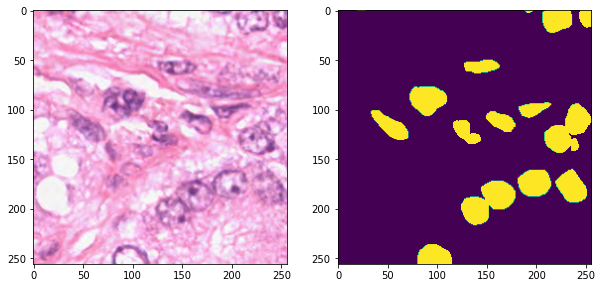

In [ ]:
i = np.random.randint(0, 1200)

print(i)

plt.figure(figsize = (10, 20))
plt.subplot(121)
plt.imshow(x[i]/255)
plt.subplot(122)
plt.imshow(y[i])

plt.show();

In [7]:
model = diu_net_model((256, 256, 3), compile = True)
#model.compile(optimizer = tf.keras.optimizers.Adam(), loss = [dice_coef_loss], metrics = [dice_coef, iou, aji])

In [ ]:
model.summary(expand_nested = True)

In [ ]:
history = model.fit(x, y, batch_size = 10, epochs = 10, verbose = 1, validation_data = (x_test, y_test))
df = history.history

Epoch 1/10
149/149 [==============================] - 133s 751ms/step - loss: 0.3332 - dice_coef: 0.7201 - iou: 0.5664 - aji: 0.3985 - val_loss: 0.4367 - val_dice_coef: 0.6485 - val_iou: 0.4805 - val_aji: 0.3169
Epoch 2/10
149/149 [==============================] - 109s 733ms/step - loss: 0.2507 - dice_coef: 0.7788 - iou: 0.6387 - aji: 0.4703 - val_loss: 0.2588 - val_dice_coef: 0.7723 - val_iou: 0.6294 - val_aji: 0.4596
Epoch 3/10
149/149 [==============================] - 111s 748ms/step - loss: 0.2303 - dice_coef: 0.7946 - iou: 0.6597 - aji: 0.4930 - val_loss: 0.2551 - val_dice_coef: 0.7750 - val_iou: 0.6330 - val_aji: 0.4636
Epoch 4/10
149/149 [==============================] - 111s 742ms/step - loss: 0.2171 - dice_coef: 0.8051 - iou: 0.6743 - aji: 0.5092 - val_loss: 0.2292 - val_dice_coef: 0.7952 - val_iou: 0.6601 - val_aji: 0.4929
Epoch 5/10
149/149 [==============================] - 111s 746ms/step - loss: 0.2091 - dice_coef: 0.8116 - iou: 0.6835 - aji: 0.5200 - val_loss: 0.2543 

### First 10 epochs

{'loss': [0.34244874119758606, 0.25340506434440613, 0.22679278254508972, 0.22419090569019318, 0.21604011952877045, 0.2043467015028, 0.20118539035320282, 0.19272738695144653, 0.18690355122089386, 0.18408028781414032], 'dice_coef': [0.7143223881721497, 0.7768176794052124, 0.7975010871887207, 0.799608588218689, 0.8060500621795654, 0.8153706192970276, 0.8180030584335327, 0.8248958587646484, 0.82973712682724, 0.8320367932319641], 'iou': [0.5599260926246643, 0.6361274719238281, 0.6639361381530762, 0.6669104099273682, 0.675757110118866, 0.6886626482009888, 0.6925132870674133, 0.7023556232452393, 0.7094533443450928, 0.7127297520637512], 'aji': [0.39271363615989685, 0.4676968455314636, 0.4979263246059418, 0.501344621181488, 0.5112119317054749, 0.5257118940353394, 0.5303243398666382, 0.5418360233306885, 0.5504133701324463, 0.554227352142334], 'val_loss': [0.2501817047595978, 0.25621071457862854, 0.27370691299438477, 0.2375662624835968, 0.22668886184692383, 0.24307923018932343, 0.2255919873714447, 0.2157987505197525, 0.20825983583927155, 0.20688138902187347], 'val_dice_coef': [0.7788372039794922, 0.774171769618988, 0.7609720826148987, 0.7887387275695801, 0.7972908616065979, 0.7844423651695251, 0.7981848120689392, 0.8059802651405334, 0.8121170997619629, 0.8132222890853882], 'val_iou': [0.6380778551101685, 0.631872296333313, 0.6148314476013184, 0.651515781879425, 0.6631361246109009, 0.6457366347312927, 0.6644054055213928, 0.6751713752746582, 0.6839046478271484, 0.6854445338249207], 'val_aji': [0.46888405084609985, 0.4622609615325928, 0.4446712136268616, 0.4836116433143616, 0.496351420879364, 0.47734376788139343, 0.497813880443573, 0.5098558664321899, 0.5200013518333435, 0.5217416882514954]}

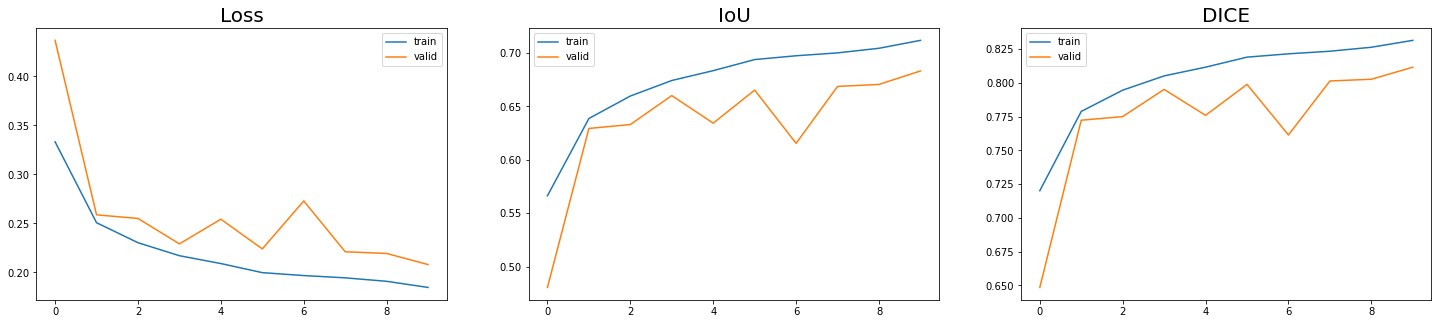

In [ ]:
plt.figure(figsize = (25, 5))

ax1 = plt.subplot(1, 3, 1)
plt.plot(history.epoch, df['loss'])
plt.plot(history.epoch, df['val_loss'])
plt.legend(("train" , "valid") , loc = 0)
plt.title('Loss', fontsize = 20) 

ax2 = plt.subplot(1, 3, 2)
plt.plot(history.epoch, df['iou'])
plt.plot(history.epoch, df['val_iou'])
plt.legend(("train" , "valid") , loc = 0)
plt.title('IoU', fontsize = 20)

ax3 = plt.subplot(1, 3, 3)
plt.plot(history.epoch, df['dice_coef'])
plt.plot(history.epoch, df['val_dice_coef'])
plt.legend(("train" , "valid") , loc = 0)
plt.title('DICE', fontsize = 20)
plt.show()

### Saving Model

### Testing

In [9]:
metadata = pd.read_json('patient_info_test.json')
organ_dict = {}
for organ in metadata['Organ'].unique():
  organ_dict[organ] = list(metadata[metadata['Organ'] == organ]['Patient ID'])
organ_dict

{'Bladder': ['TCGA-CU-A0YN-01A-02-BSB', 'TCGA-ZF-A9R5-01A-01-TS1'],
 'Brain': ['TCGA-FG-A4MU-01B-01-TS1', 'TCGA-HT-8564-01Z-00-DX1'],
 'Breast': ['TCGA-AC-A2FO-01A-01-TS1', 'TCGA-AO-A0J2-01A-01-BSA'],
 'Colon': ['TCGA-A6-6782-01A-01-BS1'],
 'Kidney': ['TCGA-2Z-A9J9-01A-01-TS1',
  'TCGA-GL-6846-01A-01-BS1',
  'TCGA-IZ-8196-01A-01-BS1'],
 'Lung': ['TCGA-44-2665-01B-06-BS6', 'TCGA-69-7764-01A-01-TS1'],
 'Prostate': ['TCGA-EJ-A46H-01A-03-TSC', 'TCGA-HC-7209-01A-01-TS1']}

In [10]:
def test_organs(imdir, msdir, model, organ_dict):
  results_dict = {k: 0 for k in organ_dict.keys()}
  for organ in organ_dict.keys():
    
    organ_x = np.zeros((len(organ_dict[organ]) * 16, 256, 256, 3), dtype = np.float32)
    organ_y = np.zeros((len(organ_dict[organ]) * 16, 256, 256), dtype = np.float32)

    image_list = [f for f in os.listdir(imdir) if f[:23] in organ_dict[organ]]
    
    for (i, f) in enumerate(image_list):
      organ_x[i] = np.array(Image.open(os.path.join(imdir, f)), dtype = np.float32)
      organ_y[i] = np.array(Image.open(os.path.join(msdir, f)), dtype = np.float32)/255.
    
    results = model.evaluate(organ_x, organ_y)
    results_dict[organ] = results

  return results_dict

In [11]:
test_im_dir = os.path.join(test_dir, 'tissues')
test_ms_dir = os.path.join(test_dir, 'masks')
test_results = test_organs(test_im_dir, test_ms_dir, model, organ_dict)

1/1 [==============================] - 1s 642ms/step - loss: 0.1710 - dice_coef: 0.8428 - iou: 0.7283 - aji: 0.5727


In [ ]:
metrics = ['Loss', 'DICE', 'IoU', 'AJI']
results_df = pd.DataFrame({k: [] for k in metrics})
for organ in test_results.keys():
  results_df.loc[organ] = test_results[organ]
results_df

,Loss,DICE,IoU,AJI
Breast,0.259131,0.771722,0.628295,0.458040
Kidney,0.209908,0.810390,0.681225,0.516560
Prostate,0.191633,0.825610,0.703012,0.542034
Bladder,0.176750,0.837989,0.721154,0.563910
Colon,0.249369,0.779293,0.638394,0.468854
Lung,0.210960,0.809807,0.680399,0.515610
Brain,0.171037,0.842791,0.728296,0.572693


In [8]:
model.load_weights('/content/drive/MyDrive/msrf/model_130522_1151/weights.h5')

In [14]:
predictions = model.predict(x_test)

In [ ]:
thresholds = [i * 0.05 for i in range(1, 20)]

In [ ]:
print('For no threshold:')
print(f'DICE: {dice_coef(y_test, predictions)}')
print(f'IoU: {iou(y_test, predictions)}\n')

for threshold in thresholds:
  predictions = (model.predict(x_test) > threshold) * 1
  predictions = predictions.astype(np.float32)
  print(f'For threshold {threshold}')
  print(f'DICE: {dice_coef(y_test, predictions)}')
  print(f'IoU: {iou(y_test, predictions)}\n')


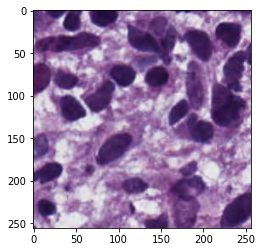

In [17]:
plt.imshow(x_test[3]/255)

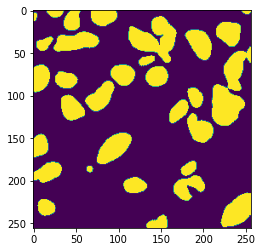

In [18]:
plt.imshow(np.squeeze((predictions[3] > 0.9) * 1.0, axis = -1))

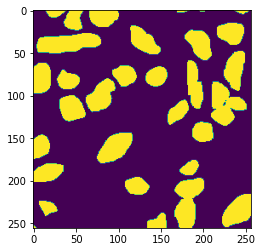

In [19]:
plt.imshow(y_test[3])